In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Đồ án biểu diễn (Dự báo giá chứng khoán)/dataset/VNM.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-12-01,20.879999,20.980000,20.750000,20.799999,20.696852,195600
1,2021-12-02,20.799999,20.850000,20.680000,20.719999,20.617249,296800
2,2021-12-03,20.500000,20.549999,20.280001,20.370001,20.268986,251000
3,2021-12-06,20.000000,20.049999,19.870001,20.010000,19.910770,502800
4,2021-12-07,20.379999,20.559999,20.320000,20.510000,20.408291,339700


In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.931326
1,0.923800
2,0.890875
3,0.857008
4,0.904045


In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

In [ ]:
def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(x=inputs, axes=[-1], keepdims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))

    params_shape = inputs.get_shape()[-1:]
    gamma = tf.compat.v1.get_variable('gamma', params_shape, tf.float32, tf.compat.v1.ones_initializer())
    beta = tf.compat.v1.get_variable('beta', params_shape, tf.float32, tf.compat.v1.zeros_initializer())

    outputs = gamma * normalized + beta
    return outputs

def multihead_attn(queries, keys, q_masks, k_masks, future_binding, num_units, num_heads):

    T_q = tf.shape(input=queries)[1]
    T_k = tf.shape(input=keys)[1]

    Q = tf.compat.v1.layers.dense(queries, num_units, name='Q')
    K_V = tf.compat.v1.layers.dense(keys, 2*num_units, name='K_V')
    K, V = tf.split(K_V, 2, -1)

    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)

    align = tf.matmul(Q_, tf.transpose(a=K_, perm=[0,2,1]))
    align = align / np.sqrt(K_.get_shape().as_list()[-1])

    paddings = tf.fill(tf.shape(input=align), float('-inf'))

    key_masks = k_masks
    key_masks = tf.tile(key_masks, [num_heads, 1])
    key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, T_q, 1])
    align = tf.compat.v1.where(tf.equal(key_masks, 0), paddings, align)

    if future_binding:
        lower_tri = tf.ones([T_q, T_k])
        lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()
        masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(input=align)[0], 1, 1])
        align = tf.compat.v1.where(tf.equal(masks, 0), paddings, align)

    align = tf.nn.softmax(align)
    query_masks = tf.cast(q_masks, dtype=tf.float32)
    query_masks = tf.tile(query_masks, [num_heads, 1])
    query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, T_k])
    align *= query_masks

    outputs = tf.matmul(align, V_)
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)
    outputs += queries
    outputs = layer_norm(outputs)
    return outputs


def pointwise_feedforward(inputs, hidden_units, activation=None):
    outputs = tf.compat.v1.layers.dense(inputs, 4*hidden_units, activation=activation)
    outputs = tf.compat.v1.layers.dense(outputs, hidden_units, activation=None)
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs


def learned_position_encoding(inputs, mask, embed_dim):
    T = tf.shape(input=inputs)[1]
    outputs = tf.range(tf.shape(input=inputs)[1])                # (T_q)
    outputs = tf.expand_dims(outputs, 0)                   # (1, T_q)
    outputs = tf.tile(outputs, [tf.shape(input=inputs)[0], 1])   # (N, T_q)
    outputs = embed_seq(outputs, T, embed_dim, zero_pad=False, scale=False)
    return tf.expand_dims(tf.cast(mask, dtype=tf.float32), -1) * outputs


def sinusoidal_position_encoding(inputs, mask, repr_dim):
    T = tf.shape(input=inputs)[1]
    pos = tf.reshape(tf.range(0.0, tf.cast(T, dtype=tf.float32), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(input=inputs)[0], 1, 1]) * tf.expand_dims(tf.cast(mask, dtype=tf.float32), -1)

def label_smoothing(inputs, epsilon=0.1):
    C = inputs.get_shape().as_list()[-1]
    return ((1 - epsilon) * inputs) + (epsilon / C)

class Attention:
    def __init__(self, size_layer, embedded_size, learning_rate, size, output_size,
                 num_blocks = 2,
                 num_heads = 8,
                 min_freq = 50):
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))

        encoder_embedded = tf.compat.v1.layers.dense(self.X, embedded_size)
        encoder_embedded = tf.nn.dropout(encoder_embedded, rate = 1 - (0.8))
        x_mean = tf.reduce_mean(input_tensor=self.X, axis = 2)
        en_masks = tf.sign(x_mean)
        encoder_embedded += sinusoidal_position_encoding(self.X, en_masks, embedded_size)

        for i in range(num_blocks):
            with tf.compat.v1.variable_scope('encoder_self_attn_%d'%i,reuse=tf.compat.v1.AUTO_REUSE):
                encoder_embedded = multihead_attn(queries = encoder_embedded,
                                             keys = encoder_embedded,
                                             q_masks = en_masks,
                                             k_masks = en_masks,
                                             future_binding = False,
                                             num_units = size_layer,
                                             num_heads = num_heads)

            with tf.compat.v1.variable_scope('encoder_feedforward_%d'%i,reuse=tf.compat.v1.AUTO_REUSE):
                encoder_embedded = pointwise_feedforward(encoder_embedded,
                                                    embedded_size,
                                                    activation = tf.nn.relu)

        self.logits = tf.compat.v1.layers.dense(encoder_embedded[-1], output_size)
        self.cost = tf.reduce_mean(input_tensor=tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.001

In [ ]:
def forecast():
    tf.compat.v1.reset_default_graph()
    modelnn = Attention(size_layer, size_layer, learning_rate, df_log.shape[1], df_log.shape[1])
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y
                },
            )
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


<ipython-input-7-86468d331b92>:91: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, embedded_size)
<ipython-input-7-86468d331b92>:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, name='Q')
<ipython-input-7-86468d331b92>:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.compat.v1.layers.dense(keys, 2*num_units, name='K_V')
<ipython-input-7-86468d331b92>:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(inputs, 4*hidden_units, activation=activation)
<ipython-input-7-86468d331b92>:56: UserWarning: `tf.layers

simulation 2


<ipython-input-7-86468d331b92>:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, name='Q')
<ipython-input-7-86468d331b92>:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.compat.v1.layers.dense(keys, 2*num_units, name='K_V')
<ipython-input-7-86468d331b92>:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(inputs, 4*hidden_units, activation=activation)
<ipython-input-7-86468d331b92>:56: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(outputs, hidden_units, activation=None)
<ipython-input-7-86468d331b92>:112: UserWarning: `

simulation 3


<ipython-input-7-86468d331b92>:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, name='Q')
<ipython-input-7-86468d331b92>:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.compat.v1.layers.dense(keys, 2*num_units, name='K_V')
<ipython-input-7-86468d331b92>:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(inputs, 4*hidden_units, activation=activation)
<ipython-input-7-86468d331b92>:56: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(outputs, hidden_units, activation=None)
<ipython-input-7-86468d331b92>:112: UserWarning: `

simulation 4


<ipython-input-7-86468d331b92>:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, name='Q')
<ipython-input-7-86468d331b92>:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.compat.v1.layers.dense(keys, 2*num_units, name='K_V')
<ipython-input-7-86468d331b92>:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(inputs, 4*hidden_units, activation=activation)
<ipython-input-7-86468d331b92>:56: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(outputs, hidden_units, activation=None)
<ipython-input-7-86468d331b92>:112: UserWarning: `

simulation 5


<ipython-input-7-86468d331b92>:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, name='Q')
<ipython-input-7-86468d331b92>:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.compat.v1.layers.dense(keys, 2*num_units, name='K_V')
<ipython-input-7-86468d331b92>:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(inputs, 4*hidden_units, activation=activation)
<ipython-input-7-86468d331b92>:56: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(outputs, hidden_units, activation=None)
<ipython-input-7-86468d331b92>:112: UserWarning: `

simulation 6


<ipython-input-7-86468d331b92>:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, name='Q')
<ipython-input-7-86468d331b92>:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.compat.v1.layers.dense(keys, 2*num_units, name='K_V')
<ipython-input-7-86468d331b92>:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(inputs, 4*hidden_units, activation=activation)
<ipython-input-7-86468d331b92>:56: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(outputs, hidden_units, activation=None)
<ipython-input-7-86468d331b92>:112: UserWarning: `

simulation 7


<ipython-input-7-86468d331b92>:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, name='Q')
<ipython-input-7-86468d331b92>:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.compat.v1.layers.dense(keys, 2*num_units, name='K_V')
<ipython-input-7-86468d331b92>:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(inputs, 4*hidden_units, activation=activation)
<ipython-input-7-86468d331b92>:56: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(outputs, hidden_units, activation=None)
<ipython-input-7-86468d331b92>:112: UserWarning: `

simulation 8


<ipython-input-7-86468d331b92>:91: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, embedded_size)
<ipython-input-7-86468d331b92>:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, name='Q')
<ipython-input-7-86468d331b92>:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.compat.v1.layers.dense(keys, 2*num_units, name='K_V')
<ipython-input-7-86468d331b92>:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(inputs, 4*hidden_units, activation=activation)
<ipython-input-7-86468d331b92>:56: UserWarning: `tf.layers

simulation 9


<ipython-input-7-86468d331b92>:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, name='Q')
<ipython-input-7-86468d331b92>:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.compat.v1.layers.dense(keys, 2*num_units, name='K_V')
<ipython-input-7-86468d331b92>:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(inputs, 4*hidden_units, activation=activation)
<ipython-input-7-86468d331b92>:56: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(outputs, hidden_units, activation=None)
<ipython-input-7-86468d331b92>:112: UserWarning: `

simulation 10


<ipython-input-7-86468d331b92>:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, name='Q')
<ipython-input-7-86468d331b92>:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.compat.v1.layers.dense(keys, 2*num_units, name='K_V')
<ipython-input-7-86468d331b92>:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(inputs, 4*hidden_units, activation=activation)
<ipython-input-7-86468d331b92>:56: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.compat.v1.layers.dense(outputs, hidden_units, activation=None)
<ipython-input-7-86468d331b92>:112: UserWarning: `

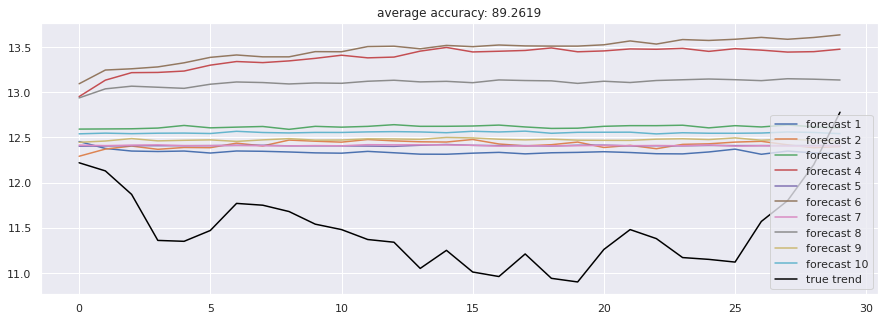

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()